In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from datetime import timedelta


import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# load price data
price_df = pd.read_csv('price_only_data.csv', index_col='Date', parse_dates=True)
returns_df = price_df.pct_change().dropna()
combined_df = pd.concat([price_df.add_suffix('_price'), returns_df.add_suffix('_return')], axis=1).dropna()
returns_tensor = torch.tensor(returns_df.values, dtype=torch.float32).to(device)

In [ ]:
combined_df

,VTI_price,AGG_price,DBC_price,^VIX_price,VTI_return,AGG_return,DBC_return,^VIX_return
Date,,,,,,,,
2006-02-08,1.007195,0.999501,0.995745,0.944077,0.007195,-0.000499,-0.004255,-0.055923
2006-02-09,1.005276,1.000100,1.005106,0.965416,-0.001905,0.000599,0.009402,0.022603
2006-02-10,1.007354,0.998003,0.986808,0.947020,0.002067,-0.002096,-0.018205,-0.019055
2006-02-13,1.002798,0.998701,0.971489,0.982340,-0.004523,0.000699,-0.015524,0.037296
2006-02-14,1.012311,0.997104,0.963404,0.901398,0.009486,-0.001600,-0.008322,-0.082397
...,...,...,...,...,...,...,...,...
2023-12-22,5.297333,1.703718,1.095870,0.958793,0.002287,-0.001314,-0.001796,-0.045421
2023-12-26,5.323525,1.707166,1.106715,0.955850,0.004944,0.002024,0.009897,-0.003070
2023-12-27,5.333599,1.718026,1.101786,0.914643,0.001892,0.006362,-0.004454,-0.043110


In [ ]:
class PortfolioNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(PortfolioNN, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lstm_out, _ = self.lstm1(x)
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        weights = self.softmax(out)
        return weights


In [ ]:
def sharpe_ratio_loss(predicted_weights, asset_returns, txn_cost=0):
    '''
    predicted weights: shape (64, N) where N is the number of assets
    asset_returns: shape (64, N, W) where W is the window
    '''
    if txn_cost > 0:
        weights = predicted_weights.detach().cpu().numpy()
        changes_in_weights = np.diff(weights, axis=0)
        absolute_changes = np.abs(changes_in_weights)
        txn_costs_per_change = absolute_changes * txn_cost

        txn_costs_per_day = np.concatenate(([0], np.sum(txn_costs_per_change, axis=1)))
        txn_costs_tensor = torch.tensor(txn_costs_per_day, dtype=torch.float32, device=predicted_weights.device).unsqueeze(1)
        predicted_weights = predicted_weights.unsqueeze(1)
        portfolio_returns = torch.sum(predicted_weights * asset_returns, dim=2) - txn_costs_tensor
    else:
        predicted_weights = predicted_weights.unsqueeze(1)
        portfolio_returns = torch.sum(predicted_weights * asset_returns, dim=2)
    mean_portfolio_return = torch.mean(portfolio_returns)
    std_portfolio_return = torch.std(portfolio_returns)

    epsilon = 1e-8
    sharpe_ratio = mean_portfolio_return / (std_portfolio_return + epsilon) * np.sqrt(252) / np.sqrt(asset_returns.shape[1])
    return -sharpe_ratio

def sharpe_ratio(predicted_weights, asset_returns, txn_cost=0):

    # calculate transaction costs
    if txn_cost > 0:
        weights = predicted_weights.detach().cpu().numpy()
        changes_in_weights = np.diff(weights, axis=0)
        absolute_changes = np.abs(changes_in_weights)
        txn_costs_per_change = absolute_changes * txn_cost

        txn_costs_per_day = np.concatenate(([0], np.sum(txn_costs_per_change, axis=1)))
        txn_costs_tensor = torch.tensor(txn_costs_per_day, dtype=torch.float32, device=predicted_weights.device).unsqueeze(1)
        predicted_weights = predicted_weights.unsqueeze(1)
        portfolio_returns = torch.sum(predicted_weights * asset_returns, dim=2) - txn_costs_tensor
    else:
        predicted_weights = predicted_weights.unsqueeze(1)
        portfolio_returns = torch.sum(predicted_weights * asset_returns, dim=2)
    mean_portfolio_return = torch.mean(portfolio_returns)
    std_portfolio_return = torch.std(portfolio_returns)

    epsilon = 1e-8
    sharpe_ratio = mean_portfolio_return / (std_portfolio_return + epsilon) * np.sqrt(252) / np.sqrt(asset_returns.shape[1])

    return sharpe_ratio.item()

def create_sequences(input_data, returns_data, lookback_window, forward_window, interval):
    xs, ys = [], []
    for i in range(0, len(input_data)-lookback_window-forward_window+1, interval):
        x = input_data[i:(i+lookback_window)]  # the prior n1 data
        y = returns_data[(i+lookback_window):(i+lookback_window+forward_window)]  # need the next n2 returns
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


In [ ]:
def generate_baseline_weights(n_rows):
    weights = [0.60, 0.40, 0.00, 0.00]
    baseline_weights = torch.tensor(weights * n_rows).reshape(n_rows, len(weights)).to(device)
    return baseline_weights

def generate_90_10(n_rows):
    weights = [0.90, 0.10, 0.00, 0.00]
    baseline_weights = torch.tensor(weights * n_rows).reshape(n_rows, len(weights)).to(device)
    return baseline_weights

def generate_mvo_weights(n_rows):
    weights = [0.27574633, 0.67558032, 0.010347, 0.03832634]
    baseline_weights = torch.tensor(weights * n_rows).reshape(n_rows, len(weights)).to(device)
    return baseline_weights

In [ ]:
# # Choose a sequence length
lookback_window = 50
forward_window = 5
interval = 1

# Convert returns DataFrame to numpy and then create sequences
X, y = create_sequences(combined_df.values, returns_df.values, lookback_window, forward_window, interval)
# train_size = int(X.shape[0] * 0.9)

# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.5,  # 10% of the data for testing
    random_state=42,  # Seed for reproducibility
    shuffle=True  # Ensure the data is shuffled before splitting
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# test sharpe ratio calculation
batch_size = 64
pred_weights = generate_mvo_weights(batch_size)
actual_returns = y_train_tensor[0:64].to(device)
sharpe_ratio_loss(pred_weights, actual_returns)

tensor(0.0220, device='cuda:0')

In [ ]:

def moving_average(data, period=10):
    return np.convolve(data, np.ones(period)/period, mode='valid')



def stats(returns_df, all_test_weights, txn_costs=0, vol_target=0, vol_lookback=50):
    if vol_target:
        squared_returns = returns_df ** 2
        ewma_variance = squared_returns.ewm(span=50, adjust=False).mean()
        ewma_volatility = ewma_variance.apply(np.sqrt)
        weight_adjustment = vol_target/ewma_volatility
        all_test_weights = all_test_weights.multiply(weight_adjustment, axis=1)
        all_test_weights = all_test_weights.div(all_test_weights.sum(axis=1), axis=0)
    shifted_weights = all_test_weights.shift(1).fillna(0)
    transaction_costs = (all_test_weights - shifted_weights).abs() * txn_costs

    # port returns
    adjusted_return = returns_df * all_test_weights - transaction_costs
    portfolio_returns = adjusted_return.sum(axis=1)
    annualized_return = np.mean(portfolio_returns) * 252

    # Annualize standard deviation
    annualized_std_dev = np.std(portfolio_returns) * np.sqrt(252)

    # Assume a risk-free rate of 0% for simplicity
    risk_free_rate = 0
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std_dev

    # Downside deviation
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_deviation = np.sqrt(np.mean(downside_returns ** 2)) * np.sqrt(252)

    # Maximum drawdown
    cumulative_returns = (1 + portfolio_returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()

    # Percentage of positive returns
    positive_ratio = len(portfolio_returns[portfolio_returns > 0]) / len(portfolio_returns)

    # Ratio between positive and negative returns
    avg_positive_returns = portfolio_returns[portfolio_returns > 0].mean()
    avg_negative_returns = portfolio_returns[portfolio_returns < 0].mean()
    pos_neg_ratio = avg_positive_returns / abs(avg_negative_returns)

    # Sortino Ratio
    sortino_ratio = (annualized_return - risk_free_rate) / downside_deviation

    # Plot portfolio returns
    # plt.figure(figsize=(14, 7))
    # plt.plot(portfolio_returns.index, (1 + portfolio_returns).cumprod(), label='Portfolio Cumulative Returns')
    # plt.title('Portfolio Cumulative Returns')
    # plt.xlabel('Date')
    # plt.ylabel('Cumulative Returns')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    # print(portfolio_returns.shape)
    # print(transaction_costs.shape)
    # print(portfolio_returns.head())
    # print(transaction_costs.head())

    return {
        #'Cumulative Return': round((1 + portfolio_returns).cumprod()[-1],3),
        'Annualized Return': round(annualized_return,3),
        'Annualized Standard Deviation': round(annualized_std_dev,3),
        'Sharpe Ratio': round(sharpe_ratio,3),
        'Sortino Ratio': round(sortino_ratio,3),
        'DD': round(downside_deviation,3),
        'MDD': round(max_drawdown,3),
        '% Postive Returns': round(positive_ratio,3),
        'Ave P/Ave L': round(pos_neg_ratio,3)
    }


test 0.6188616752624512
Sharpe Baseline Train 0.30652737617492676
Sharpe Baseline Test 0.8369936347007751
Sharpe 90-10 Train 0.16748563945293427
Sharpe 90-10 Test 0.6462256908416748
Sharpe MVO Train 1.2720718383789062
Sharpe MVO Test 2.6655921936035156
test 3.2823679447174072
Sharpe Baseline Train 0.42870861291885376
Sharpe Baseline Test 2.0493040084838867
Sharpe 90-10 Train 0.2834441363811493
Sharpe 90-10 Test 1.9948704242706299
Sharpe MVO Train 1.472703456878662
Sharpe MVO Test 2.733982801437378
test 1.9927490949630737
Sharpe Baseline Train 0.6140300035476685
Sharpe Baseline Test 0.5364657044410706
Sharpe 90-10 Train 0.48296791315078735
Sharpe 90-10 Test 0.45095622539520264
Sharpe MVO Train 1.6241832971572876
Sharpe MVO Test 1.680045247077942
test 3.5849814414978027
Sharpe Baseline Train 0.5978078842163086
Sharpe Baseline Test 1.0843818187713623
Sharpe 90-10 Train 0.4743342101573944
Sharpe 90-10 Test 1.0316740274429321
Sharpe MVO Train 1.618381142616272
Sharpe MVO Test 1.894780039787

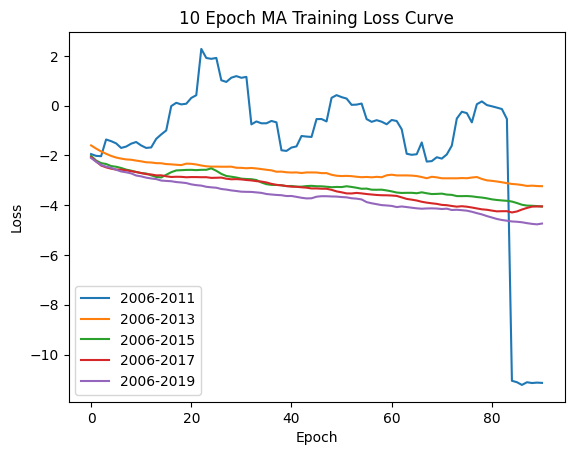

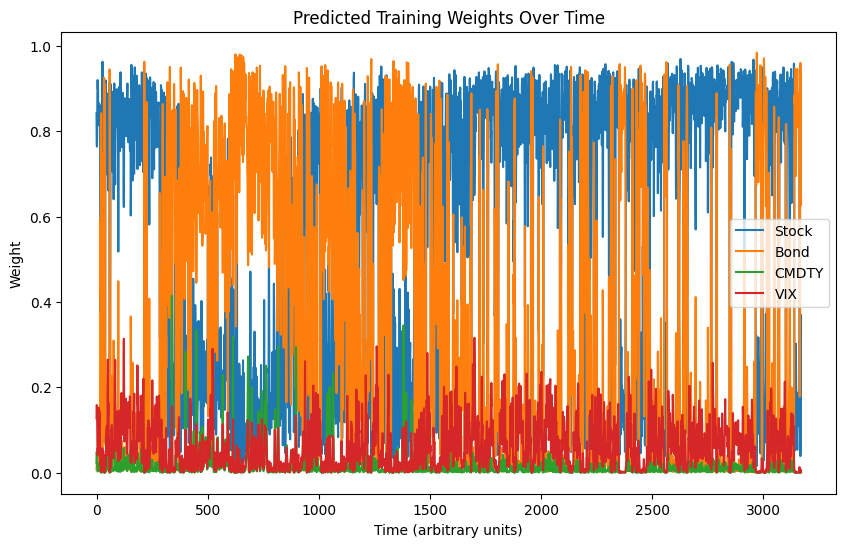

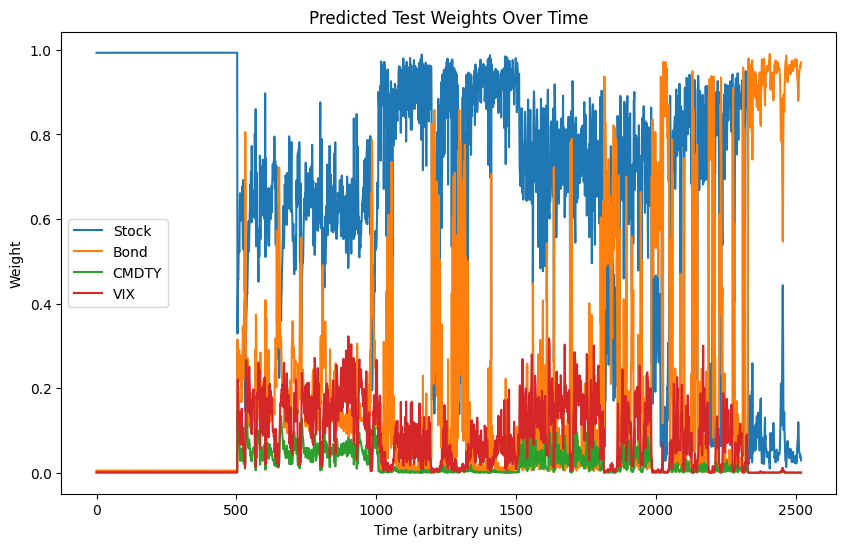

{'Annualized Return': 0.251, 'Annualized Standard Deviation': 0.134, 'Sharpe Ratio': 1.875, 'Sortino Ratio': 2.041, 'DD': 0.123, 'MDD': -0.2, '% Postive Returns': 0.56, 'Ave P/Ave L': 1.169}
test 1.198264241218567
Sharpe Baseline Train 0.30652737617492676
Sharpe Baseline Test 0.8369936347007751
Sharpe 90-10 Train 0.16748563945293427
Sharpe 90-10 Test 0.6462256908416748
Sharpe MVO Train 1.2720718383789062
Sharpe MVO Test 2.6655921936035156
test 2.610966444015503
Sharpe Baseline Train 0.42870861291885376
Sharpe Baseline Test 2.0493040084838867
Sharpe 90-10 Train 0.2834441363811493
Sharpe 90-10 Test 1.9948704242706299
Sharpe MVO Train 1.472703456878662
Sharpe MVO Test 2.733982801437378
test 1.4150015115737915
Sharpe Baseline Train 0.6140300035476685
Sharpe Baseline Test 0.5364657044410706
Sharpe 90-10 Train 0.48296791315078735
Sharpe 90-10 Test 0.45095622539520264
Sharpe MVO Train 1.6241832971572876
Sharpe MVO Test 1.680045247077942
test 3.2436532974243164
Sharpe Baseline Train 0.59780788

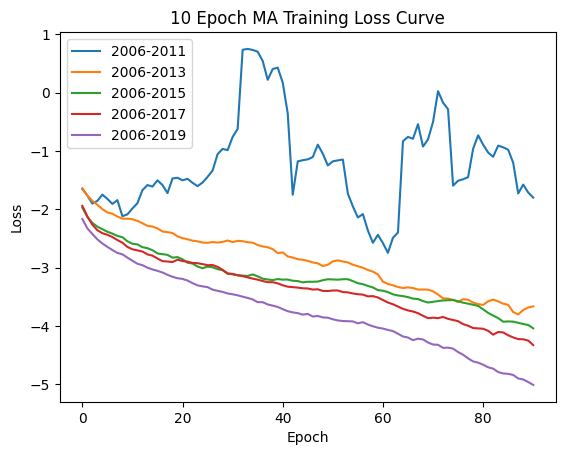

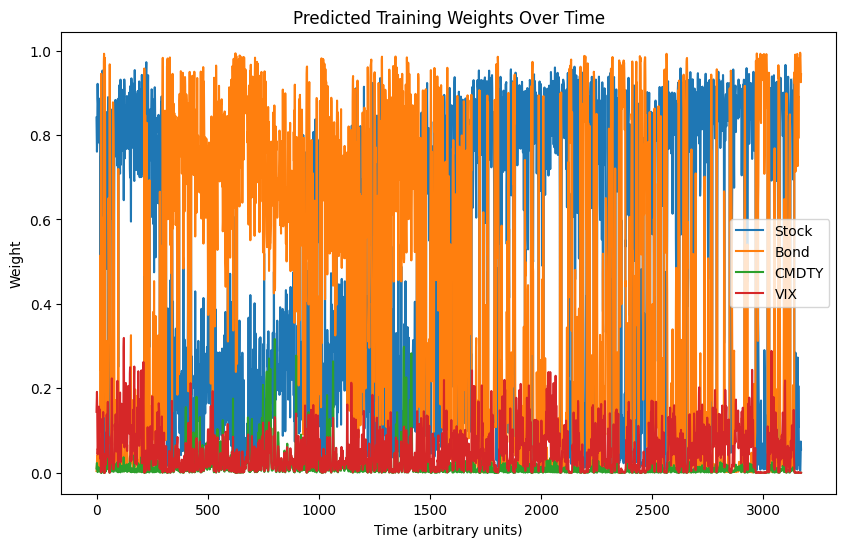

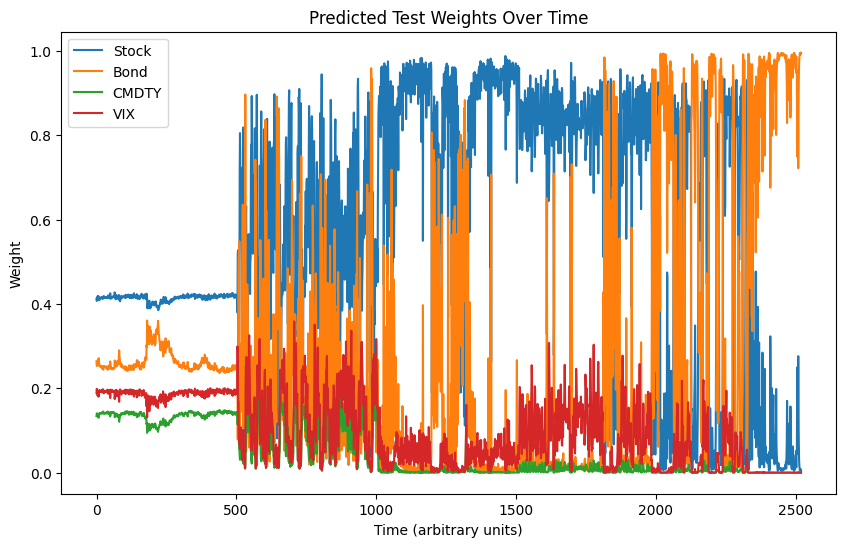

{'Annualized Return': 0.209, 'Annualized Standard Deviation': 0.121, 'Sharpe Ratio': 1.731, 'Sortino Ratio': 1.964, 'DD': 0.107, 'MDD': -0.205, '% Postive Returns': 0.546, 'Ave P/Ave L': 1.186}
test 0.5561423301696777
Sharpe Baseline Train 0.30652737617492676
Sharpe Baseline Test 0.8369936347007751
Sharpe 90-10 Train 0.16748563945293427
Sharpe 90-10 Test 0.6462256908416748
Sharpe MVO Train 1.2720718383789062
Sharpe MVO Test 2.6655921936035156
test 3.712439775466919
Sharpe Baseline Train 0.42870861291885376
Sharpe Baseline Test 2.0493040084838867
Sharpe 90-10 Train 0.2834441363811493
Sharpe 90-10 Test 1.9948704242706299
Sharpe MVO Train 1.472703456878662
Sharpe MVO Test 2.733982801437378
test 1.9376050233840942
Sharpe Baseline Train 0.6140300035476685
Sharpe Baseline Test 0.5364657044410706
Sharpe 90-10 Train 0.48296791315078735
Sharpe 90-10 Test 0.45095622539520264
Sharpe MVO Train 1.6241832971572876
Sharpe MVO Test 1.680045247077942
test 3.3568227291107178
Sharpe Baseline Train 0.5978

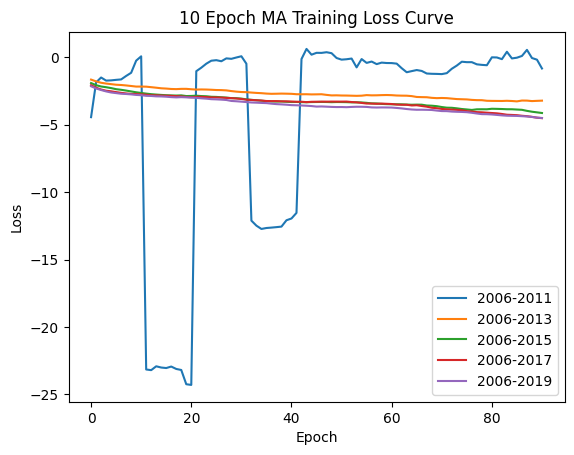

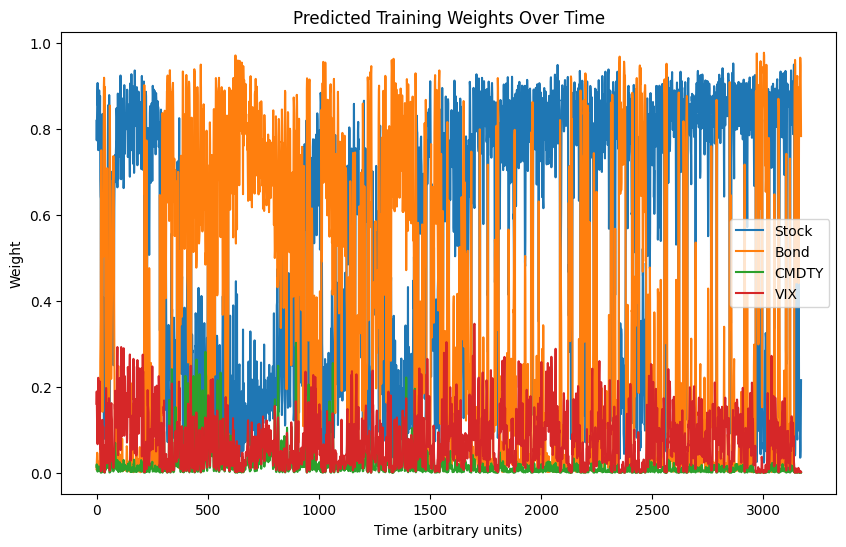

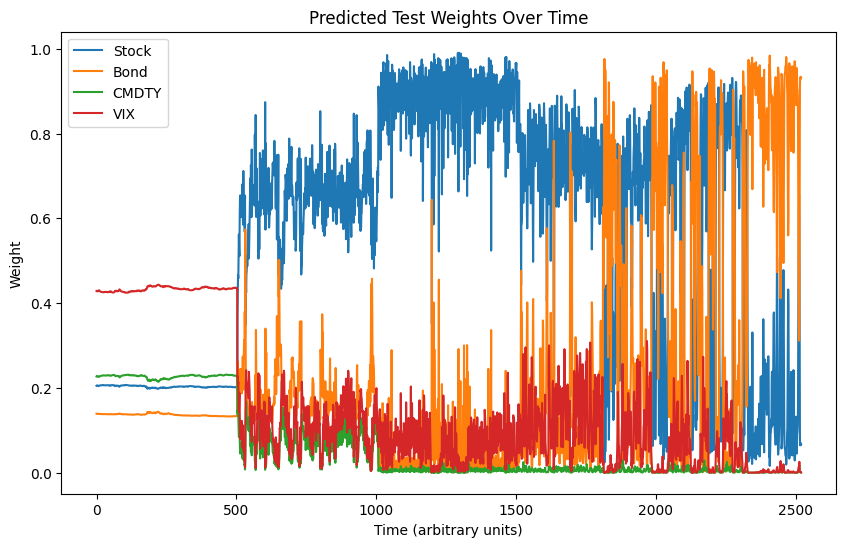

{'Annualized Return': 0.27, 'Annualized Standard Deviation': 0.232, 'Sharpe Ratio': 1.165, 'Sortino Ratio': 1.36, 'DD': 0.198, 'MDD': -0.289, '% Postive Returns': 0.552, 'Ave P/Ave L': 1.081}
test 2.085569143295288
Sharpe Baseline Train 0.30652737617492676
Sharpe Baseline Test 0.8369936347007751
Sharpe 90-10 Train 0.16748563945293427
Sharpe 90-10 Test 0.6462256908416748
Sharpe MVO Train 1.2720718383789062
Sharpe MVO Test 2.6655921936035156
test 2.671631097793579
Sharpe Baseline Train 0.42870861291885376
Sharpe Baseline Test 2.0493040084838867
Sharpe 90-10 Train 0.2834441363811493
Sharpe 90-10 Test 1.9948704242706299
Sharpe MVO Train 1.472703456878662
Sharpe MVO Test 2.733982801437378
test 2.121311902999878
Sharpe Baseline Train 0.6140300035476685
Sharpe Baseline Test 0.5364657044410706
Sharpe 90-10 Train 0.48296791315078735
Sharpe 90-10 Test 0.45095622539520264
Sharpe MVO Train 1.6241832971572876
Sharpe MVO Test 1.680045247077942
test 2.9709043502807617
Sharpe Baseline Train 0.59780788

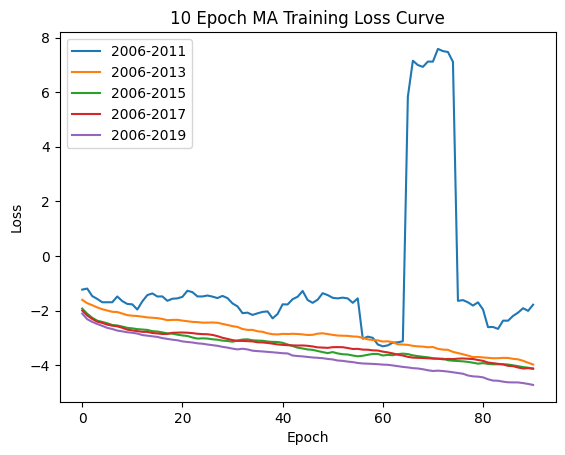

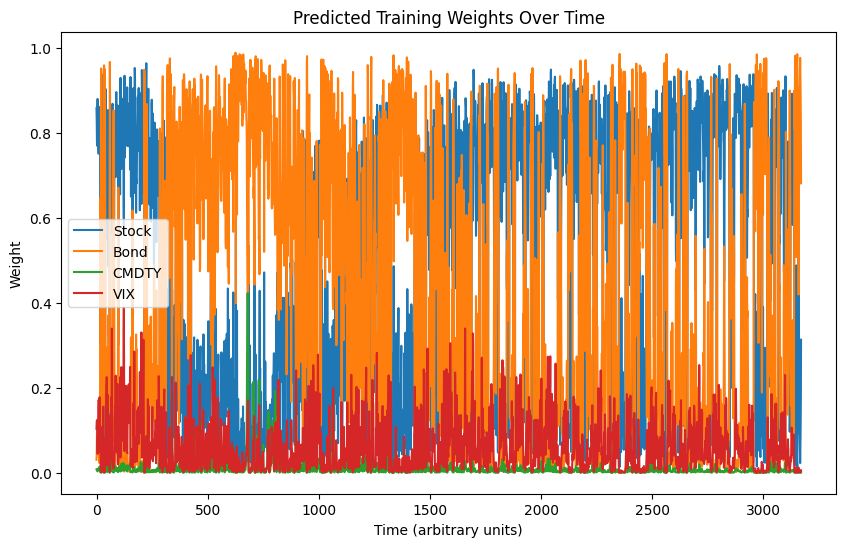

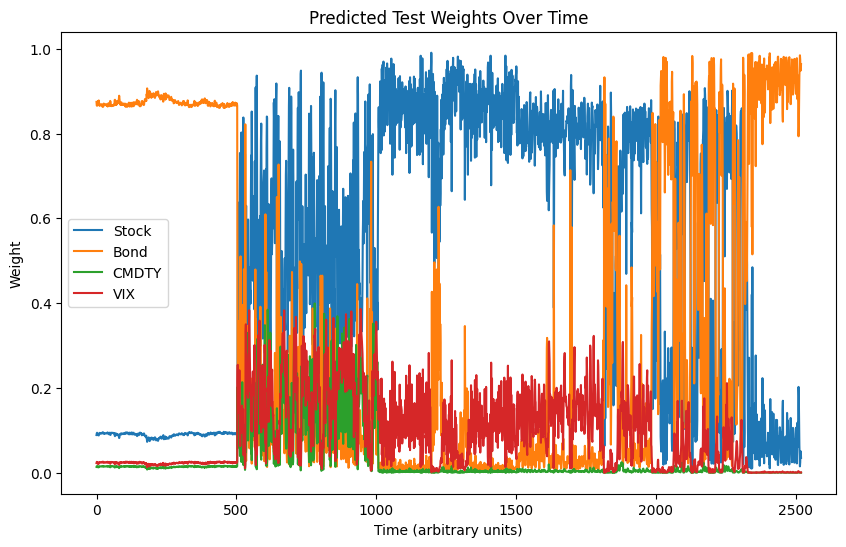

{'Annualized Return': 0.235, 'Annualized Standard Deviation': 0.116, 'Sharpe Ratio': 2.023, 'Sortino Ratio': 2.498, 'DD': 0.094, 'MDD': -0.147, '% Postive Returns': 0.548, 'Ave P/Ave L': 1.296}
test 1.4384987354278564
Sharpe Baseline Train 0.30652737617492676
Sharpe Baseline Test 0.8369936347007751
Sharpe 90-10 Train 0.16748563945293427
Sharpe 90-10 Test 0.6462256908416748
Sharpe MVO Train 1.2720718383789062
Sharpe MVO Test 2.6655921936035156
test 2.9948177337646484
Sharpe Baseline Train 0.42870861291885376
Sharpe Baseline Test 2.0493040084838867
Sharpe 90-10 Train 0.2834441363811493
Sharpe 90-10 Test 1.9948704242706299
Sharpe MVO Train 1.472703456878662
Sharpe MVO Test 2.733982801437378
test 2.2587618827819824
Sharpe Baseline Train 0.6140300035476685
Sharpe Baseline Test 0.5364657044410706
Sharpe 90-10 Train 0.48296791315078735
Sharpe 90-10 Test 0.45095622539520264
Sharpe MVO Train 1.6241832971572876
Sharpe MVO Test 1.680045247077942
test 3.2250514030456543
Sharpe Baseline Train 0.597

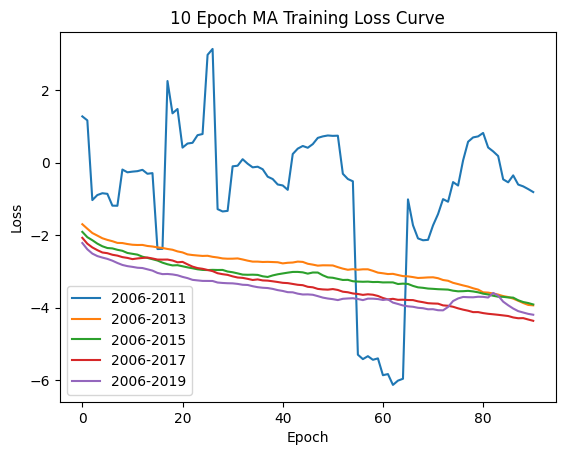

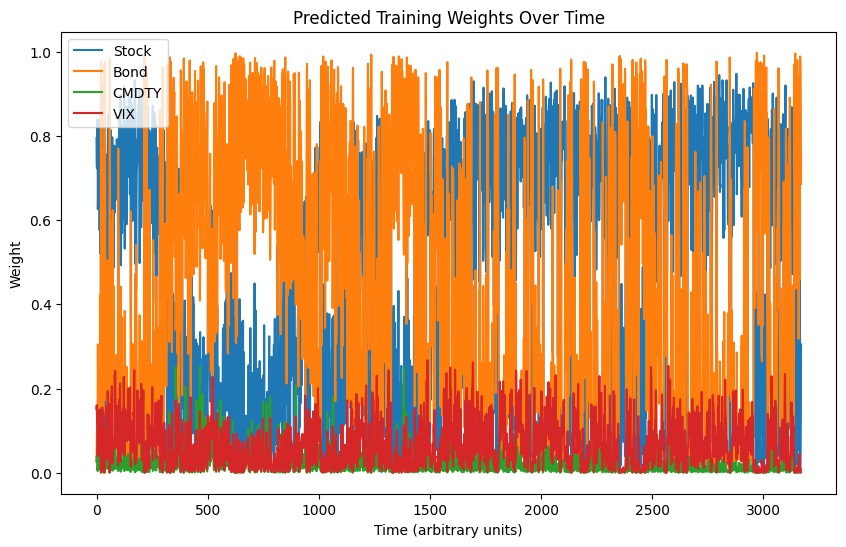

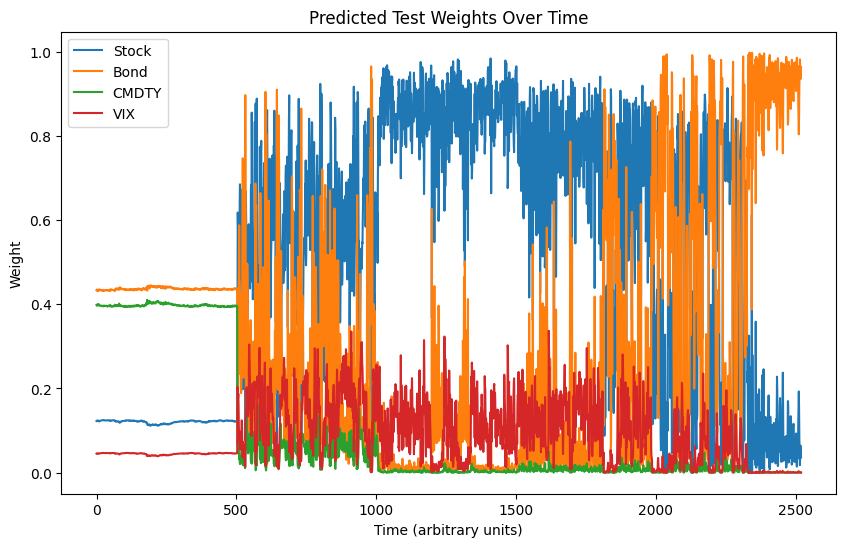

{'Annualized Return': 0.232, 'Annualized Standard Deviation': 0.108, 'Sharpe Ratio': 2.154, 'Sortino Ratio': 2.496, 'DD': 0.093, 'MDD': -0.167, '% Postive Returns': 0.56, 'Ave P/Ave L': 1.235}
test 0.6240580677986145
Sharpe Baseline Train 0.30652737617492676
Sharpe Baseline Test 0.8369936347007751
Sharpe 90-10 Train 0.16748563945293427
Sharpe 90-10 Test 0.6462256908416748
Sharpe MVO Train 1.2720718383789062
Sharpe MVO Test 2.6655921936035156
test 3.6917731761932373
Sharpe Baseline Train 0.42870861291885376
Sharpe Baseline Test 2.0493040084838867
Sharpe 90-10 Train 0.2834441363811493
Sharpe 90-10 Test 1.9948704242706299
Sharpe MVO Train 1.472703456878662
Sharpe MVO Test 2.733982801437378
test 2.247131586074829
Sharpe Baseline Train 0.6140300035476685
Sharpe Baseline Test 0.5364657044410706
Sharpe 90-10 Train 0.48296791315078735
Sharpe 90-10 Test 0.45095622539520264
Sharpe MVO Train 1.6241832971572876
Sharpe MVO Test 1.680045247077942
test 3.645794630050659
Sharpe Baseline Train 0.597807

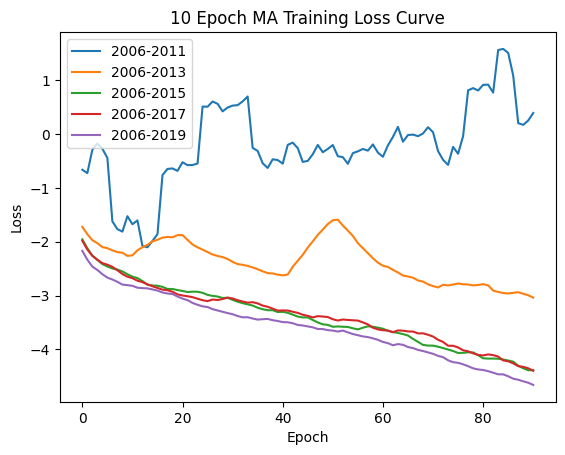

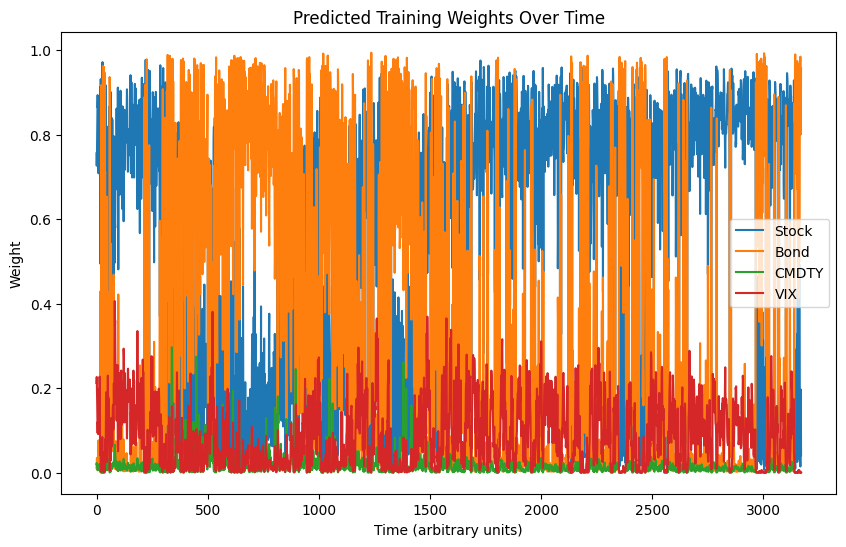

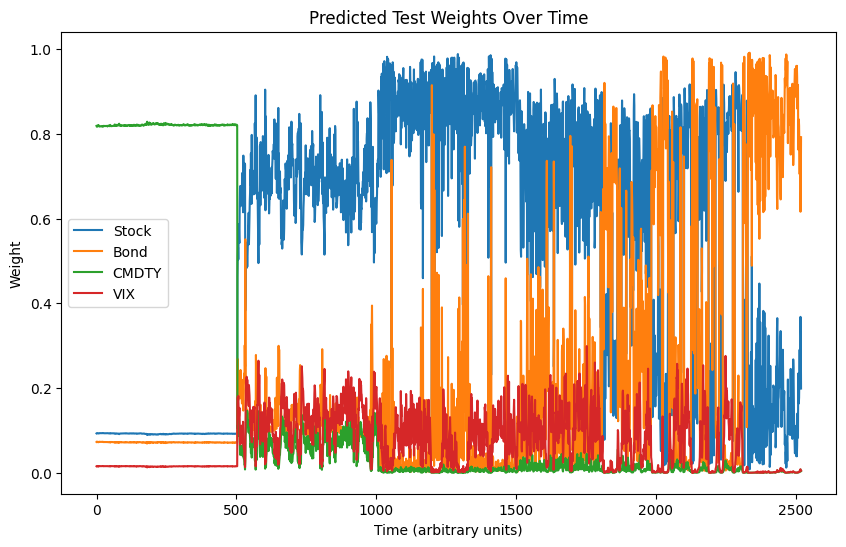

{'Annualized Return': 0.225, 'Annualized Standard Deviation': 0.112, 'Sharpe Ratio': 2.002, 'Sortino Ratio': 2.075, 'DD': 0.109, 'MDD': -0.181, '% Postive Returns': 0.565, 'Ave P/Ave L': 1.138}
test 0.6696084141731262
Sharpe Baseline Train 0.30652737617492676
Sharpe Baseline Test 0.8369936347007751
Sharpe 90-10 Train 0.16748563945293427
Sharpe 90-10 Test 0.6462256908416748
Sharpe MVO Train 1.2720718383789062
Sharpe MVO Test 2.6655921936035156
test 2.9649088382720947
Sharpe Baseline Train 0.42870861291885376
Sharpe Baseline Test 2.0493040084838867
Sharpe 90-10 Train 0.2834441363811493
Sharpe 90-10 Test 1.9948704242706299
Sharpe MVO Train 1.472703456878662
Sharpe MVO Test 2.733982801437378
test 2.116988182067871
Sharpe Baseline Train 0.6140300035476685
Sharpe Baseline Test 0.5364657044410706
Sharpe 90-10 Train 0.48296791315078735
Sharpe 90-10 Test 0.45095622539520264
Sharpe MVO Train 1.6241832971572876
Sharpe MVO Test 1.680045247077942
test 3.5682578086853027
Sharpe Baseline Train 0.5978

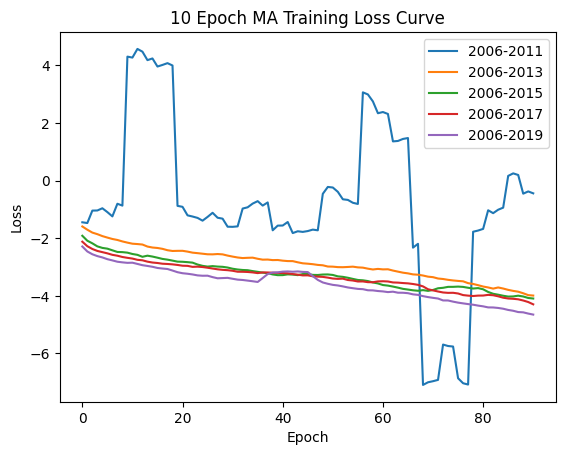

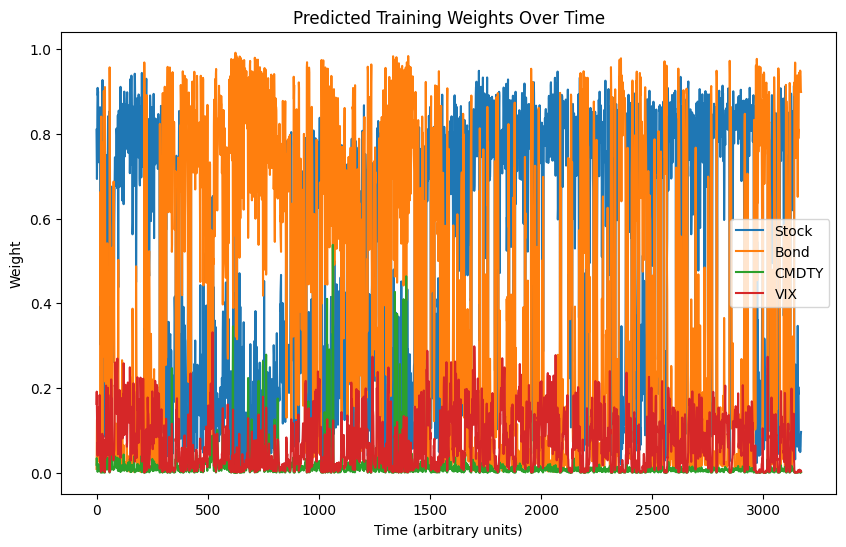

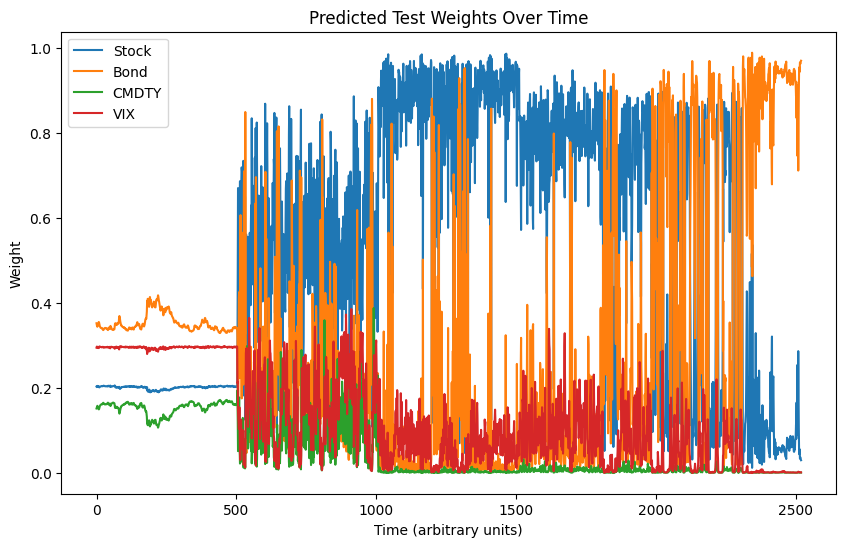

{'Annualized Return': 0.245, 'Annualized Standard Deviation': 0.174, 'Sharpe Ratio': 1.406, 'Sortino Ratio': 1.655, 'DD': 0.148, 'MDD': -0.183, '% Postive Returns': 0.544, 'Ave P/Ave L': 1.148}
test 0.8576474785804749
Sharpe Baseline Train 0.30652737617492676
Sharpe Baseline Test 0.8369936347007751
Sharpe 90-10 Train 0.16748563945293427
Sharpe 90-10 Test 0.6462256908416748
Sharpe MVO Train 1.2720718383789062
Sharpe MVO Test 2.6655921936035156
test 2.750227212905884
Sharpe Baseline Train 0.42870861291885376
Sharpe Baseline Test 2.0493040084838867
Sharpe 90-10 Train 0.2834441363811493
Sharpe 90-10 Test 1.9948704242706299
Sharpe MVO Train 1.472703456878662
Sharpe MVO Test 2.733982801437378
test 2.451463460922241
Sharpe Baseline Train 0.6140300035476685
Sharpe Baseline Test 0.5364657044410706
Sharpe 90-10 Train 0.48296791315078735
Sharpe 90-10 Test 0.45095622539520264
Sharpe MVO Train 1.6241832971572876
Sharpe MVO Test 1.680045247077942
test 3.3772847652435303
Sharpe Baseline Train 0.59780

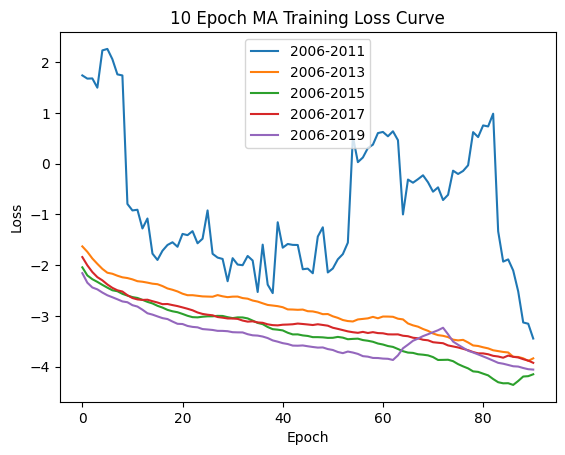

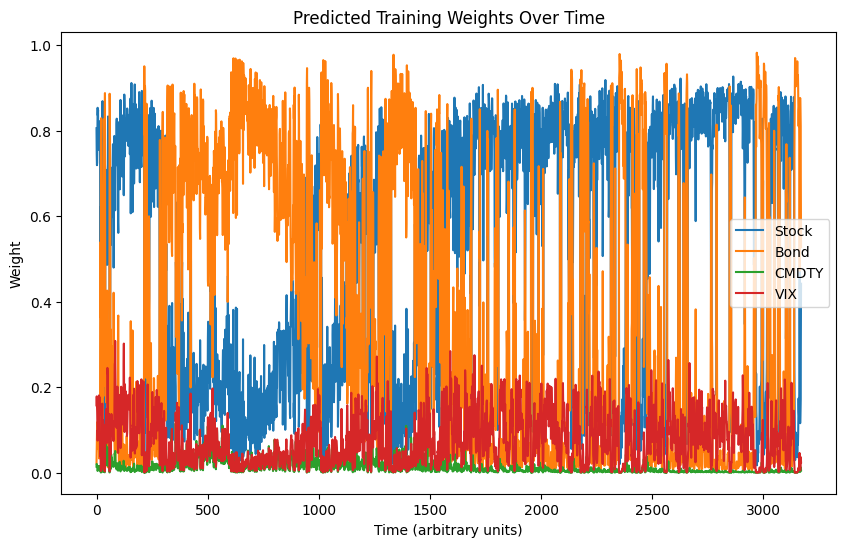

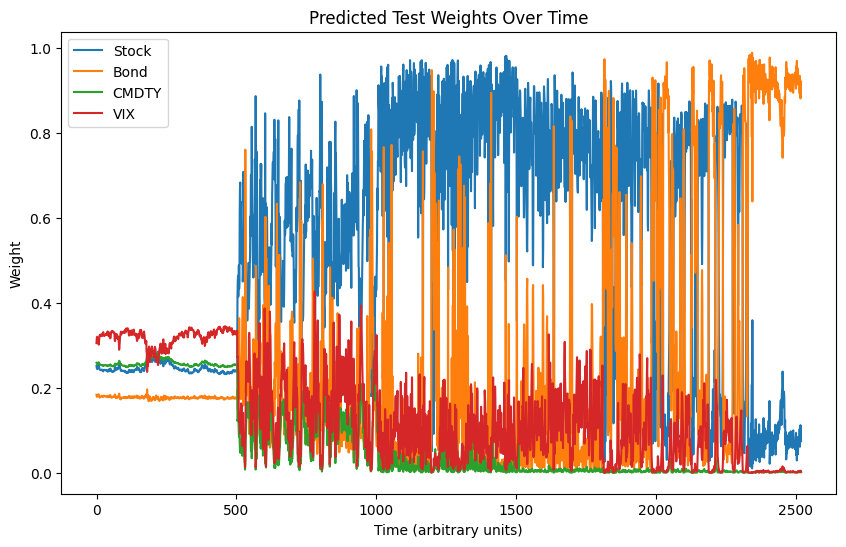

{'Annualized Return': 0.283, 'Annualized Standard Deviation': 0.18, 'Sharpe Ratio': 1.571, 'Sortino Ratio': 1.925, 'DD': 0.147, 'MDD': -0.181, '% Postive Returns': 0.546, 'Ave P/Ave L': 1.184}
test 1.2845208644866943
Sharpe Baseline Train 0.30652737617492676
Sharpe Baseline Test 0.8369936347007751
Sharpe 90-10 Train 0.16748563945293427
Sharpe 90-10 Test 0.6462256908416748
Sharpe MVO Train 1.2720718383789062
Sharpe MVO Test 2.6655921936035156
test 3.5175118446350098
Sharpe Baseline Train 0.42870861291885376
Sharpe Baseline Test 2.0493040084838867
Sharpe 90-10 Train 0.2834441363811493
Sharpe 90-10 Test 1.9948704242706299
Sharpe MVO Train 1.472703456878662
Sharpe MVO Test 2.733982801437378
test 1.8662641048431396
Sharpe Baseline Train 0.6140300035476685
Sharpe Baseline Test 0.5364657044410706
Sharpe 90-10 Train 0.48296791315078735
Sharpe 90-10 Test 0.45095622539520264
Sharpe MVO Train 1.6241832971572876
Sharpe MVO Test 1.680045247077942
test 3.2540385723114014
Sharpe Baseline Train 0.5978

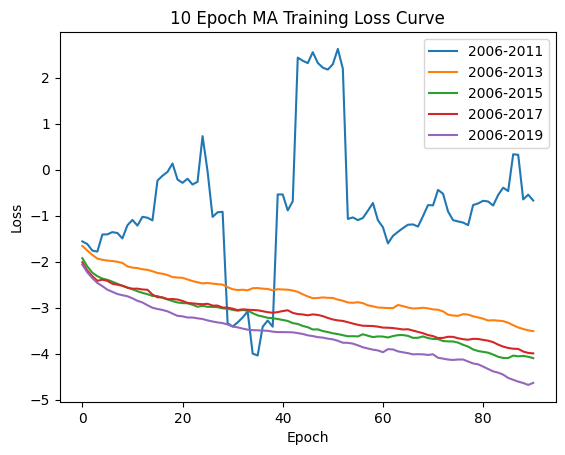

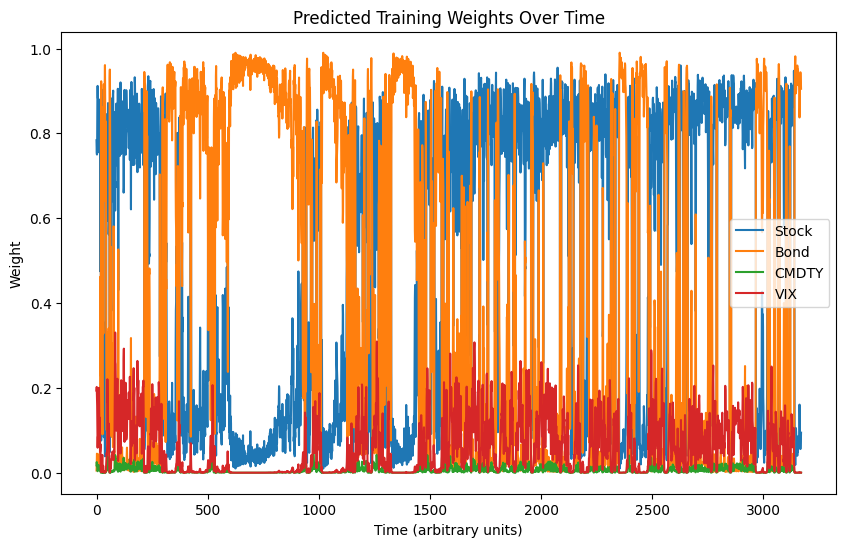

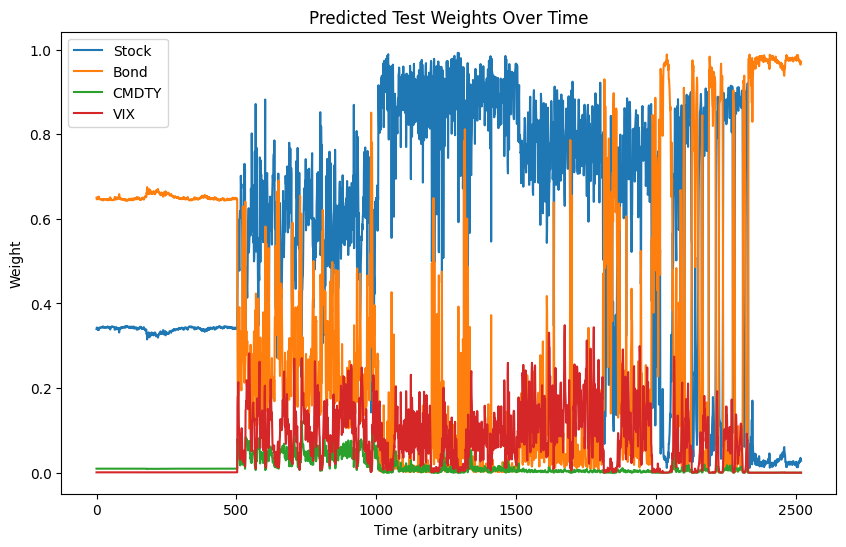

{'Annualized Return': 0.222, 'Annualized Standard Deviation': 0.098, 'Sharpe Ratio': 2.259, 'Sortino Ratio': 2.675, 'DD': 0.083, 'MDD': -0.128, '% Postive Returns': 0.565, 'Ave P/Ave L': 1.242}
test 0.7810174822807312
Sharpe Baseline Train 0.30652737617492676
Sharpe Baseline Test 0.8369936347007751
Sharpe 90-10 Train 0.16748563945293427
Sharpe 90-10 Test 0.6462256908416748
Sharpe MVO Train 1.2720718383789062
Sharpe MVO Test 2.6655921936035156
test 3.1523470878601074
Sharpe Baseline Train 0.42870861291885376
Sharpe Baseline Test 2.0493040084838867
Sharpe 90-10 Train 0.2834441363811493
Sharpe 90-10 Test 1.9948704242706299
Sharpe MVO Train 1.472703456878662
Sharpe MVO Test 2.733982801437378
test 2.2394790649414062
Sharpe Baseline Train 0.6140300035476685
Sharpe Baseline Test 0.5364657044410706
Sharpe 90-10 Train 0.48296791315078735
Sharpe 90-10 Test 0.45095622539520264
Sharpe MVO Train 1.6241832971572876
Sharpe MVO Test 1.680045247077942
test 3.0855612754821777
Sharpe Baseline Train 0.597

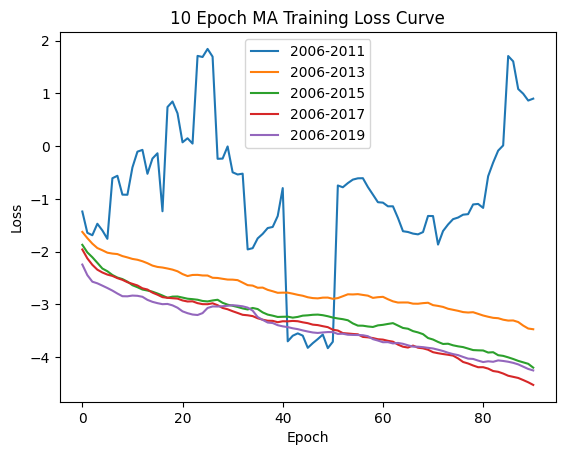

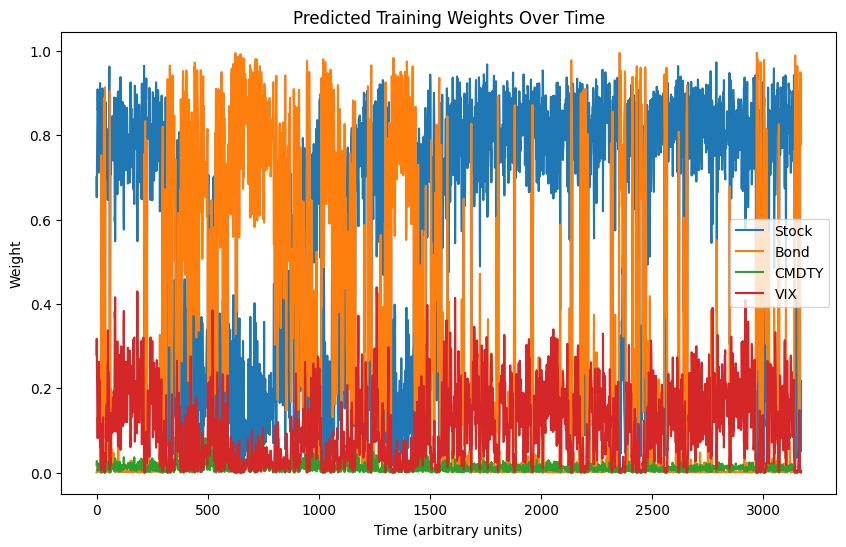

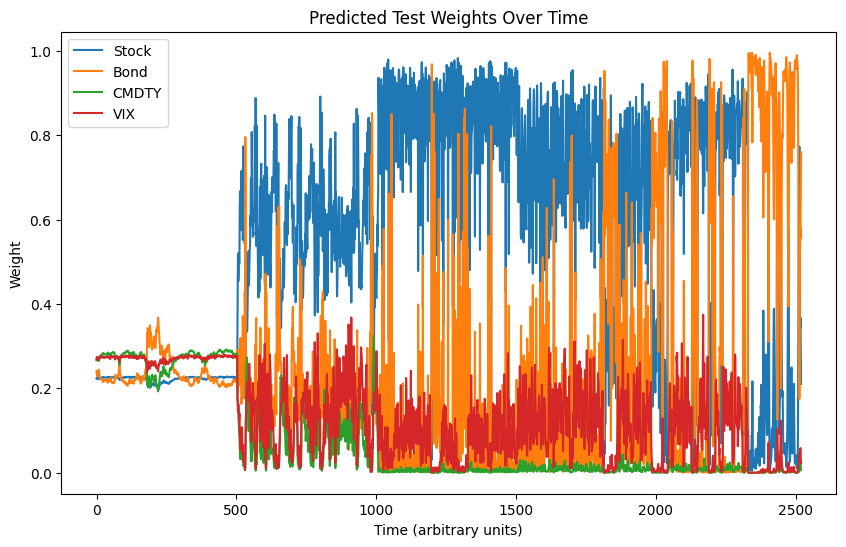

{'Annualized Return': 0.286, 'Annualized Standard Deviation': 0.165, 'Sharpe Ratio': 1.736, 'Sortino Ratio': 2.126, 'DD': 0.134, 'MDD': -0.155, '% Postive Returns': 0.545, 'Ave P/Ave L': 1.211}


In [ ]:
stored_stats = []
for i in range(10):
    train_scores = []
    test_scores = []
    benchmark_train_scores = []
    benchmark_test_scores = []
    stock_9010_train_scores = []
    stock_9010_test_scores = []
    mvo_train_scores = []
    mvo_test_scores = []
    all_epoch_loss = []
    all_test_weights = []
    transaction_costs = []

    # create the full sequences series
    lookback_window = 50
    forward_window = 1
    interval = 1
    X, y = create_sequences(combined_df.values, returns_df.values, lookback_window, forward_window, interval)
    train_txn_cost = 0
    test_txn_cost = 0.0001

    for i in range(5):
        # hyperparams
        lr = 0.001
        num_epochs = 100
        hidden_dim = 64
        batch_size = 64
        num_layers = 1

        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=3300-(504*i),  # move it up every two years
            random_state=42,
            shuffle=False
        )

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

        X_test_tensor = X_test_tensor[:504]
        y_test_tensor = y_test_tensor[:504]

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # non CV loop
        # instantiate model
        model = PortfolioNN(input_dim=X_train.shape[2], hidden_dim=hidden_dim, output_dim=y_train.shape[2], num_layers=num_layers).to(device)
        optimizer = torch.optim.Adam(model.parameters())

        # Training loop
        avg_epoch_loss = []
        for epoch in range(num_epochs):
            batch_loss = []
            for sequences, returns in train_loader:
                sequences, returns = sequences.to(device), returns.to(device)
                optimizer.zero_grad()
                predicted_weights = model(sequences)
                loss = sharpe_ratio_loss(predicted_weights, returns, txn_cost=train_txn_cost)
                batch_loss.append(loss.item())
                loss.backward()
                optimizer.step()
            avg_epoch_loss.append(np.mean(batch_loss))
            if epoch % 10 == 9:
                pass
                #print(f'Epoch {epoch+1} : Avg Sharpe {-np.mean(avg_epoch_loss[-10:])}')
                #print(predicted_weights[0])
        all_epoch_loss.append(avg_epoch_loss)

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

        model.eval()
        # first lets test it against all of the training set
        with torch.no_grad():
            for sequences, returns in train_loader:
                sequences, returns = sequences.to(device), returns.to(device)
                predicted_weights = model(sequences)
                train_predicted_weights = predicted_weights
                train_actual_returns = returns
        #print('train', sharpe_ratio(train_predicted_weights, train_actual_returns, txn_cost=train_txn_cost))
        train_scores.append(sharpe_ratio(train_predicted_weights, train_actual_returns, txn_cost=train_txn_cost))

        # test against the test set
        with torch.no_grad():
            for sequences, returns in test_loader:
                sequences, returns = sequences.to(device), returns.to(device)
                predicted_weights = model(sequences)
                test_predicted_weights = predicted_weights
                test_actual_returns = returns
        print('test', sharpe_ratio(test_predicted_weights, test_actual_returns, txn_cost=test_txn_cost))
        test_scores.append(sharpe_ratio(test_predicted_weights, test_actual_returns, txn_cost=test_txn_cost))
        all_test_weights += test_predicted_weights.tolist()


        print('Sharpe Baseline Train', sharpe_ratio(generate_baseline_weights(len(train_dataset)), train_actual_returns))
        print('Sharpe Baseline Test', sharpe_ratio(generate_baseline_weights(len(test_dataset)), test_actual_returns))
        benchmark_train_scores.append(sharpe_ratio(generate_baseline_weights(len(train_dataset)), train_actual_returns))
        benchmark_test_scores.append(sharpe_ratio(generate_baseline_weights(len(test_dataset)), test_actual_returns))

        print('Sharpe 90-10 Train', sharpe_ratio(generate_90_10(len(train_dataset)), train_actual_returns))
        print('Sharpe 90-10 Test', sharpe_ratio(generate_90_10(len(test_dataset)), test_actual_returns))
        stock_9010_train_scores.append(sharpe_ratio(generate_90_10(len(train_dataset)), train_actual_returns))
        stock_9010_test_scores.append(sharpe_ratio(generate_90_10(len(test_dataset)), test_actual_returns))

        print('Sharpe MVO Train', sharpe_ratio(generate_mvo_weights(len(train_dataset)), train_actual_returns))
        print('Sharpe MVO Test', sharpe_ratio(generate_mvo_weights(len(test_dataset)), test_actual_returns))
        mvo_train_scores.append(sharpe_ratio(generate_mvo_weights(len(train_dataset)), train_actual_returns))
        mvo_test_scores.append(sharpe_ratio(generate_mvo_weights(len(test_dataset)), test_actual_returns))

        model_train_avg = np.mean(train_scores)
        model_train_std = np.std(train_scores)
        model_test_avg = np.mean(test_scores)
        model_test_std = np.std(test_scores)
        benchmark_train_avg = np.mean(benchmark_train_scores)
        benchmark_train_std = np.std(benchmark_train_scores)
        benchmark_test_avg = np.mean(benchmark_test_scores)
        benchmark_test_std = np.std(benchmark_test_scores)
        stocks_9010_train_avg = np.mean(stock_9010_train_scores)
        stocks_9010__train_std = np.std(stock_9010_train_scores)
        stocks_9010__test_avg = np.mean(stock_9010_test_scores)
        stocks_9010__test_std = np.std(stock_9010_test_scores)
        mvo_train_avg = np.mean(mvo_train_scores)
        mvo_train_std = np.std(mvo_train_scores)
        mvo_test_avg = np.mean(mvo_test_scores)
        mvo_test_std = np.std(mvo_test_scores)

        # print('Training Sharpe over 10 Runs, 100 epochs:', round(model_train_avg,3), '+/-', round(model_train_std,3))
        # print('Testing Sharpe over 10 Runs, 100 epochs: ', round(model_test_avg,3), '+/-', round(model_test_std,3))
        # print('60/40 Sharpe on Train:                   ', round(benchmark_train_avg,3), '+/-', round(benchmark_train_std,3))
        # print('60/40 Sharpe on Test:                    ', round(benchmark_test_avg,3), '+/-', round(benchmark_test_std,5))
        # print('90/10 Sharpe on Train:                   ', round(stocks_9010_train_avg,3), '+/-', round(stocks_9010__train_std,3))
        # print('90/10 Sharpe on Test:                    ', round(stocks_9010__test_avg,3), '+/-', round(stocks_9010__test_std,3))
        # print('Markowitz Sharpe on Train:               ', round(mvo_train_avg,3), '+/-', round(mvo_train_std,3))
        # print('Markowitz Sharpe on Test:                ', round(mvo_test_avg,3), '+/-', round(mvo_test_std,3))
    # Assuming all_epoch_loss is a list of lists with your data
    all_epoch_loss_ma = [moving_average(epoch_loss) for epoch_loss in all_epoch_loss]

    # Plot each list's moving average
    plt.plot(all_epoch_loss_ma[0], label='2006-2011')
    plt.plot(all_epoch_loss_ma[1], label='2006-2013')
    plt.plot(all_epoch_loss_ma[2], label='2006-2015')
    plt.plot(all_epoch_loss_ma[3], label='2006-2017')
    plt.plot(all_epoch_loss_ma[4], label='2006-2019')

    # Adding labels and legend
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('10 Epoch MA Training Loss Curve')
    plt.legend()
    plt.show()


    # Plotting train results
    train_predicted_weights_numpy = train_predicted_weights.detach().cpu().numpy()
    plt.figure(figsize=(10, 6))
    plt.plot(train_predicted_weights_numpy[:, 0], label='Stock')
    plt.plot(train_predicted_weights_numpy[:, 1], label='Bond')
    plt.plot(train_predicted_weights_numpy[:, 2], label='CMDTY')
    plt.plot(train_predicted_weights_numpy[:, 3], label='VIX')
    plt.title('Predicted Training Weights Over Time')
    plt.xlabel('Time (arbitrary units)')
    plt.ylabel('Weight')
    plt.legend()
    plt.show()


    # plotting test
    test_weights_numpy = np.array(all_test_weights)
    plt.figure(figsize=(10, 6))
    plt.plot(test_weights_numpy[:, 0], label='Stock')
    plt.plot(test_weights_numpy[:, 1], label='Bond')
    plt.plot(test_weights_numpy[:, 2], label='CMDTY')
    plt.plot(test_weights_numpy[:, 3], label='VIX')
    plt.title('Predicted Test Weights Over Time')
    plt.xlabel('Time (arbitrary units)')
    plt.ylabel('Weight')
    plt.legend()
    plt.show()
    test_df = returns_df[1205:(1205+2520)]
    test_weights_df = pd.DataFrame(all_test_weights, index=test_df.index, columns=test_df.columns)
    test_weights_df.head()
    print(stats(test_df, test_weights_df, txn_costs=0.0001, vol_target=0, vol_lookback=50))
    stored_stats += stats(test_df, test_weights_df, txn_costs=0.0001, vol_target=0, vol_lookback=50)

Build out test stats